## Exercise 2.5

Write a nonstationary version of the 10-armed bandit algorithm to demonstrate that sample mean estimation for Q value is inefficient in a nonstationary assumption. To demonstrate this, write a modified version of the algorithm with the following rules:

- q*(a) starts equal
- runs for 10,000 steps
- for each step, each q*(a) changes randomly following a random walk (adding noise from gaussian distribution, mean 0, std_dev 0.01
- adopts epsilon-greedy action-value method with $\epsilon = 0.1$

Finally, test also an exponentially weighted estimation using $\alpha = 0.1$

Produce a plot of the average reward for each step and a plot of the percentage of optimal actions taken (optimal actions: those with maximum Q*)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Bandit():

    def __init__(self, n_bandits, max_steps):
        self.n_bandits = n_bandits
        self.max_steps = max_steps

        self.dev_stars = 1
        self.rw_mean = 0
        self.rw_std = 0.01

        self.reset()

    
    def reset(self):
        self.mean_reward_per_step = []
        self.optimal_action_pct = []
        self.n_optimal_actions = 0
        self.total_reward = 0
        self.q_stars = np.zeros(self.n_bandits)
        self.curr_steps = 0
        self.done = False

    
    def step(self, action):
        # Update number of steps
        self.curr_steps += 1
        
        # Update Optimal Action Counting
        opt_action = np.argmax(self.q_stars)
        if opt_action == action:
            self.n_optimal_actions +=1
        self.optimal_action_pct.append(self.n_optimal_actions/self.curr_steps)

        

        # Computing Reward and appending to reward list
        reward = np.random.normal(self.q_stars[action], self.dev_stars)
        self.total_reward += reward
        self.mean_reward_per_step.append(self.total_reward/self.curr_steps)

        # Updating action values
        for idx  in range(len(self.q_stars)):
            self.q_stars[idx] += np.random.normal(self.rw_mean, self.rw_std)

        if self.curr_steps == self.max_steps:
            self.done = True
            
        return reward, self.done

    
    def plot_results(self):
        fig, axes = plt.subplots(2, 1, figsize=(20, 20))

        axes[0].plot(self.mean_reward_per_step, label="Mean reward achieved")
        axes[0].set_xlabel("Steps")
        axes[0].set_ylabel("Average Reward")
        axes[0].set_title("Mean Reward per step")

        axes[1].plot(np.array(self.optimal_action_pct)*100, label="Mean reward achieved")
        axes[1].set_xlabel("Steps")
        axes[1].set_ylabel("% of Optimal Actions")
        axes[1].set_title("% of Optimal Actions per step")

    def get_results(self):
        return self.mean_reward_per_step, self.optimal_action_pct

In [9]:
class Agent():

    def __init__(self, n_actions, exponential=False):
        self.n_actions = n_actions
        self.exponential = exponential
        self.epsilon = 0.1
        self.alfa = 0.1
        self.reset()


    def reset(self):
        self.initialize_estimates_()

    
    def initialize_estimates_(self):
        estimates = []
        for i in range(self.n_actions):
            estimates.append((np.random.normal(0, 1), 0))
        self.action_estimates = estimates

    
    def choose_action(self):
        rand_number = np.random.uniform()
        if rand_number < self.epsilon:
            return np.random.randint(0, self.n_actions)
        else:
            values = [val for val, n in self.action_estimates]
            return np.argmax(values)
        

    def update_action(self, action, reward):
        value, n_action = self.action_estimates[action]
        n_action += 1
        if self.exponential:
            value += self.alfa * (reward - value)
        else:
            value += 1/n_action * (reward - value)
            
        self.action_estimates[action] = (value, n_action)
            

In [28]:
def plot_experiment_results(list_rewards, list_actions, list_rewards_exp, list_actions_exp):

    list_rewards =  np.mean(np.array(list_rewards), axis=0)
    list_actions =  np.mean(np.array(list_actions), axis=0)

    list_rewards_exp =  np.mean(np.array(list_rewards_exp), axis=0)
    list_actions_exp =  np.mean(np.array(list_actions_exp), axis=0)

    
    fig, axes = plt.subplots(2, 1, figsize=(20, 20))

    axes[0].plot(list_rewards, label="Mean reward achieved with sample mean")
    axes[0].plot(list_rewards_exp, label="Mean reward achieved with exponential decay")
    axes[0].set_xlabel("Steps")
    axes[0].set_ylabel("Average Reward")
    axes[0].set_title("Mean Reward per step")
    axes[0].legend()

    axes[1].plot(list_actions*100, label="% of optimal actions per step with sample mean")
    axes[1].plot(list_actions_exp*100, label="% of optimal actions per step with exponential decay")
    axes[1].set_xlabel("Steps")
    axes[1].set_ylabel("% of Optimal Actions")
    axes[1].set_title("% of Optimal Actions per step")
    axes[1].legend()


In [29]:
def play_one_episode(env, agent):
    env.reset()
    agent.initialize_estimates_
    done = False
    while not env.done:
        action = agent.choose_action()
        reward, done = env.step(action)
        agent.update_action(action, reward)
    
    return env.get_results()

In [30]:
def experiment(n_runs, n_bandits, n_steps):
    np.random.seed(1)
    env = Bandit(n_bandits, n_steps)
    agent = Agent(n_bandits, exponential=False)

    rew_list = []
    act_list = []
    for i in range(n_runs):
        rewards, actions = play_one_episode(env, agent)
        rew_list.append(rewards)
        act_list.append(actions)


    np.random.seed(1)
    env = Bandit(n_bandits, n_steps)
    agent = Agent(n_bandits, exponential=True)

    rew_list_exp = []
    act_list_exp = []
    for i in range(n_runs):
        rewards, actions = play_one_episode(env, agent)
        rew_list_exp.append(rewards)
        act_list_exp.append(actions)

    
    
    plot_experiment_results(rew_list, act_list, rew_list_exp, act_list_exp)

In [33]:
n_bandits = 10
n_steps = 10000
n_runs = 100

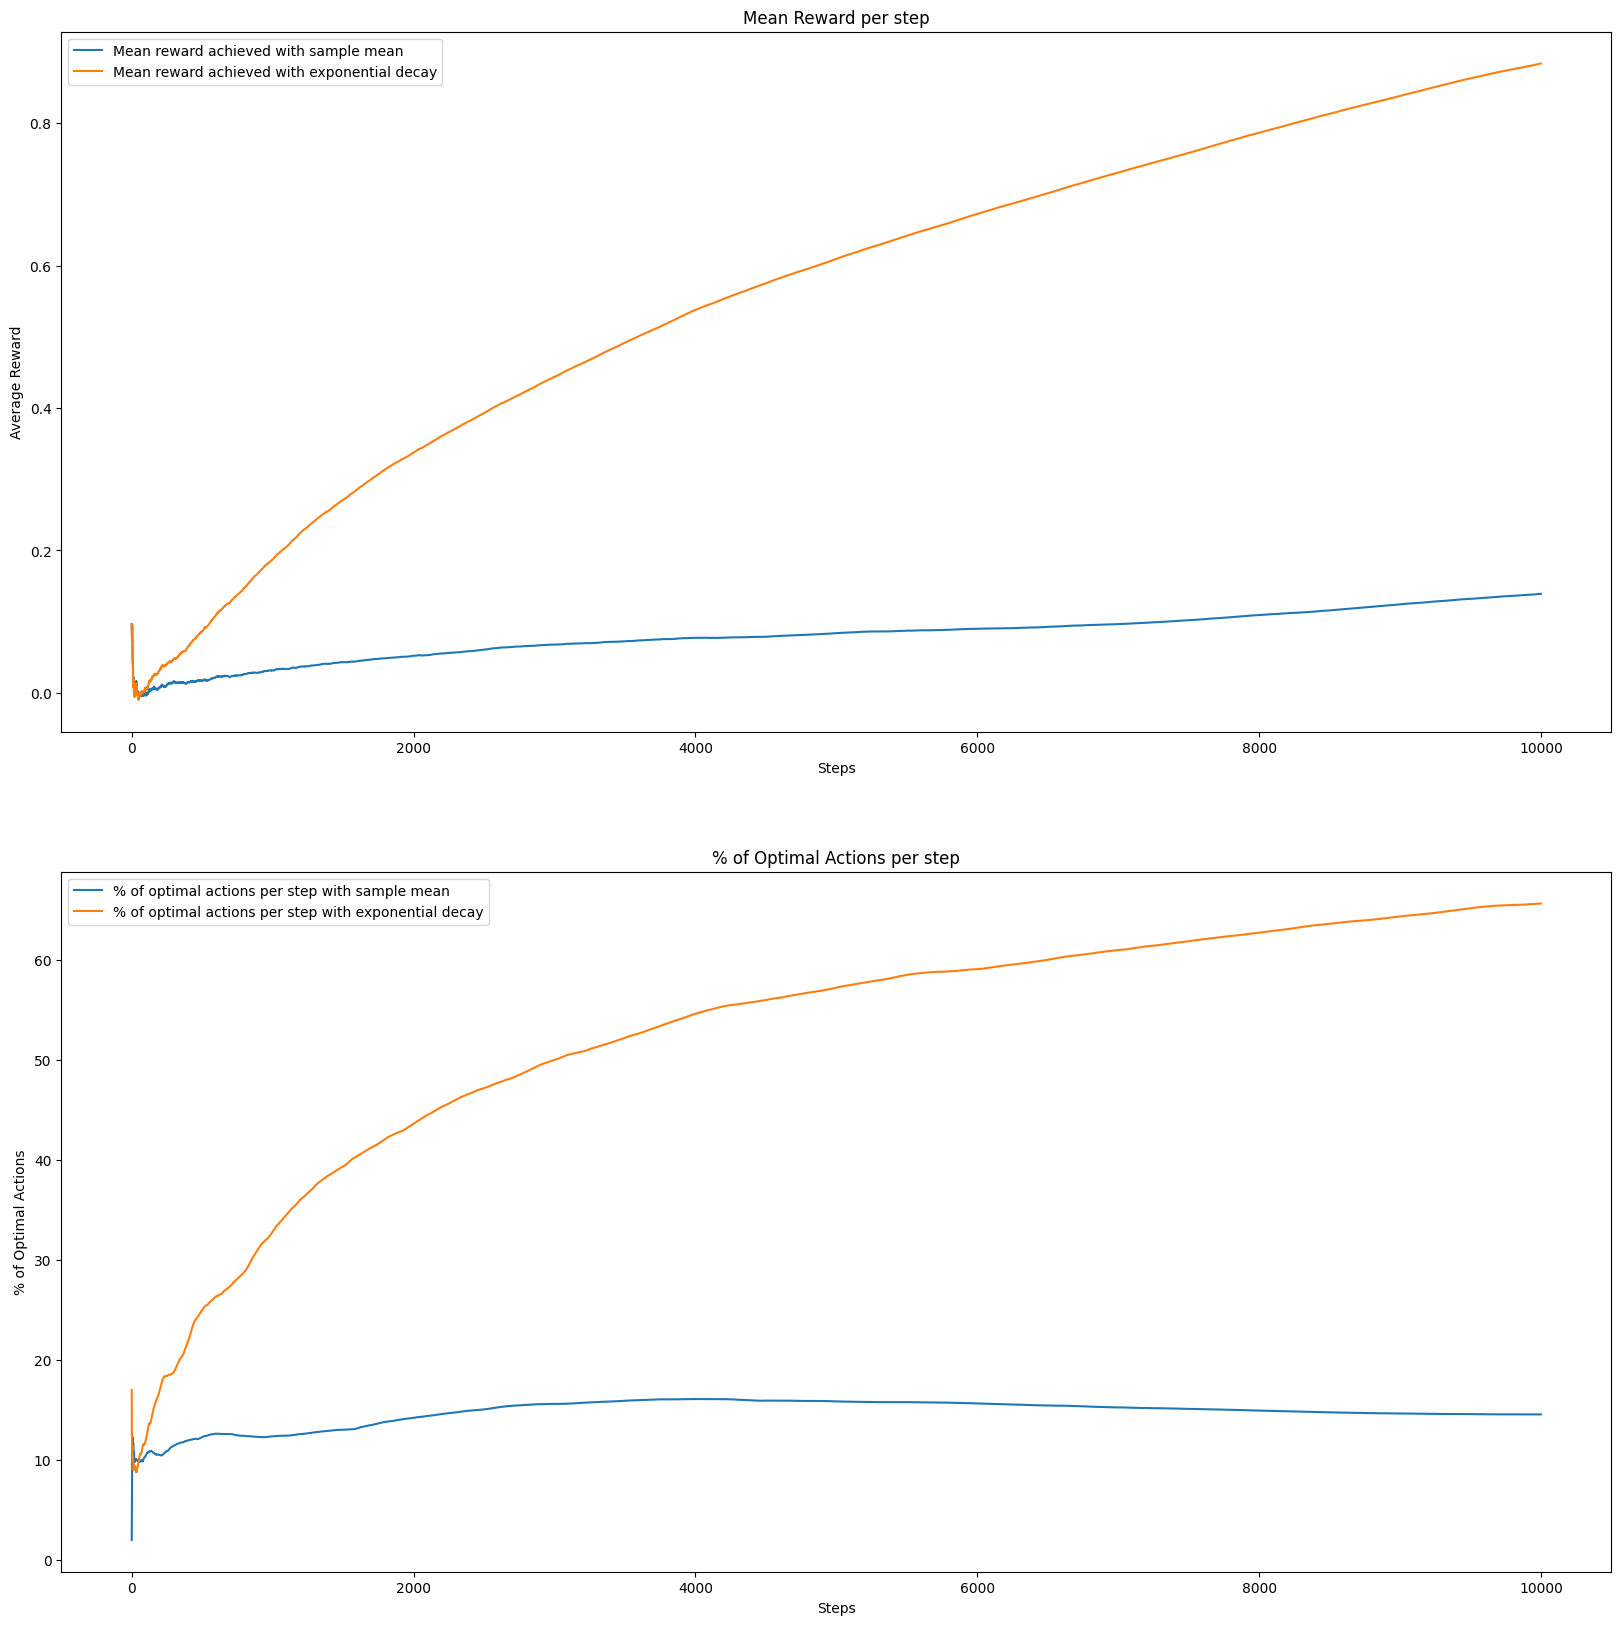

In [34]:
experiment(n_runs, n_bandits, n_steps)